# Training data processing - 10X Multiome
### Chaozhong Liu

This is the notebook for pre-processing the training data. 

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from matplotlib import colors

import os
import anndata


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load the data from phase1v2 common folders, you might need to change the path here.

In [2]:
input_mod1 = ad.read_h5ad('common/openproblems_bmmc_multiome_phase1v2/openproblems_bmmc_multiome_phase1v2.manual_formatting.output_rna.h5ad')
input_mod2 = ad.read_h5ad('common/openproblems_bmmc_multiome_phase1v2/openproblems_bmmc_multiome_phase1v2.manual_formatting.output_mod2.h5ad')


### Filterging cells and features

#### Filtering GEX genes


We selected highly-variable genes in GEX and overlapped with ATAC activity score genes.  
The gene list is saved in **data/gene_index.txt**.  
Here we will just read in the gene list and select.

In [3]:
gene_index = open('data/gene_index.txt','r').readlines()
gene_index = [i.strip() for i in gene_index]
gene_index = np.array(gene_index)

input_mod1 = input_mod1[:,gene_index]

We created new AnnData with activity score as X

In [4]:
input_mod2_gene = ad.AnnData(
    X = input_mod2.obsm['gene_activity'],
    obs = input_mod2.obs,
)

input_mod2_gene.var_names = input_mod2.uns['gene_activity_var_names']

input_mod2_gene = input_mod2_gene[:,gene_index]


### Filtering cells

To filter cells, we removed cells based on **MT gene proportion**, **counts** and **number of genes expressed**. And we also removed validation batches s1d2 and s3d7.  
The cell list is saved in **data/cell_index.txt**.  
Here we will just read in the cell list and select.

In [5]:
cell_index = open('data/cell_index.txt','r').readlines()
cell_index = [i.strip() for i in cell_index]
cell_index = np.array(cell_index)

input_mod1 = input_mod1[cell_index]
input_mod2_gene = input_mod2_gene[cell_index]

In [6]:
input_mod1

View of AnnData object with n_obs × n_vars = 28089 × 4876
    obs: 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'cell_type', 'pseudotime_order_GEX', 'batch', 'pseudotime_order_ATAC', 'is_train'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'dataset_id', 'organism'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [7]:
input_mod2_gene

View of AnnData object with n_obs × n_vars = 28089 × 4876
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train'

In [8]:
#This is not the final data for GEX, but is needed next. It will be overwritten later.
input_mod1.write('data/Multiome_GEX_processed.training.ACT.h5ad')
#This is the final training data for ATAC, save it in data/
input_mod2_gene.write('data/Multiome_ATAC_processed.training.ACT.h5ad')


### Define KNN Graph and shortest distance between all cell pairs

Next we will define a KNN graph using GEX data.  
This is needed during training.   


In [2]:
input_train_mod1 = ad.read_h5ad('data/Multiome_GEX_processed.training.ACT.h5ad')
sc.pp.highly_variable_genes(input_train_mod1)
input_mod1 = input_train_mod1.copy() #[:,input_train_mod1.var.highly_variable].copy()
sc.pp.combat(input_mod1)

/mnt/hdd/chaozhong/pylib/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


/mnt/hdd/chaozhong/pylib/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


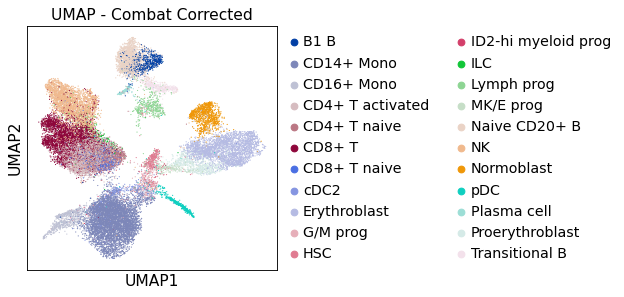

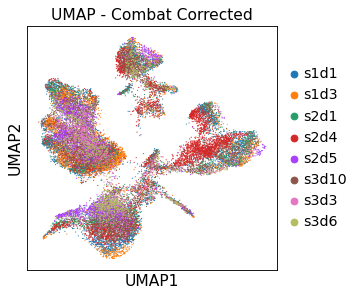

In [3]:
sc.pp.highly_variable_genes(input_mod1)
input_mod1 = input_mod1[:,input_mod1.var.highly_variable]
sc.pp.scale(input_mod1, max_value=10)
sc.tl.pca(input_mod1, svd_solver='arpack')
sc.pp.neighbors(input_mod1, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(input_mod1)

#UMAP with Combat batch correction and all genes
sc.set_figure_params(scanpy=True, dpi=80)
sc.pl.umap(input_mod1, color="cell_type", title="UMAP - Combat Corrected", show=True) #, legend_loc='on data')
sc.pl.umap(input_mod1, color="batch", title="UMAP - Combat Corrected", show=True)


In [4]:
input_mod1.obsp['connectivities'][input_mod1.obsp['connectivities'].nonzero()] = 1.01 - input_mod1.obsp['connectivities'][input_mod1.obsp['connectivities'].nonzero()]



In [5]:
#--------------------------------------------------------------------
# This takes time, but saves more time during training
#--------------------------------------------------------------------
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
import time

start_time = time.time()
dist_matrix = dijkstra(csgraph=input_mod1.obsp['connectivities'], directed=False, return_predecessors=False)
print("--- %s seconds ---" % (time.time() - start_time))


--- 1346.6577818393707 seconds ---


In [6]:
input_train_mod1.obsp['distance'] = dist_matrix
input_train_mod1.write('data/Multiome_GEX_processed.training.ACT.h5ad')
